# **COMP 562 Group Project**
# **Loan Default Prediction Model**
### Kang Du, Jingtong E, Zhengnan Feng, Zihao Fang
### 730359227, 730365307, 730321222, 730352968



# Set Up:
- Import the required libraris to run our Notebook
- Pull 'p' Proportion of the Lending Club Dataset 


In [1]:
# Import libraries and mount drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

In [2]:
#Pulling out p% of the Data Set. We lowered this during our exploratory phase.
p = 1
#Reading the data from 2007 to 2018 
data = pd.read_csv("accepted_2007_to_2018Q4.csv", header = 0, skiprows = lambda i: i > 0 and random.random() > p)

#56849 rows, 151 variables.
print("Dataframe shape is", data.shape)

C:\Users\kangd\AppData\Local\Temp\ipykernel_99544\1853535592.py:4: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("accepted_2007_to_2018Q4.csv", header = 0, skiprows = lambda i: i > 0 and random.random() > p)


Dataframe shape is (2260701, 151)


# Take a cursory examination of our data 
- Use the head method to display the first 5 observations
- Use the describe method to obtain summary statistics on our variables
- Initialize 3 lists with each one containing the variables of a speciifc data type

In [3]:
#Taking a look at the first five rows from our data 
data.head()


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


# Variable Selection
- We looked at the description of each variable in the codebook provided and narrowed down the data to just include features of concern

- Engineer the 'Fico' varaiable from the borrower's Fico score range 

In [4]:
#Chosen features
cols = ['open_acc','funded_amnt', 'int_rate','term','verification_status','annual_inc',	'dti',	'installment',	'application_type',	'emp_length',	'grade','sub_grade',	'home_ownership',	'loan_status',	'fico_range_high','fico_range_low','issue_d']
#Print out the cols to ensure the list was properly initialized
cols

['open_acc',
 'funded_amnt',
 'int_rate',
 'term',
 'verification_status',
 'annual_inc',
 'dti',
 'installment',
 'application_type',
 'emp_length',
 'grade',
 'sub_grade',
 'home_ownership',
 'loan_status',
 'fico_range_high',
 'fico_range_low',
 'issue_d']

In [5]:
#Makes a copy of the data with only the columns we are interested in
data = data[cols].copy()

In [6]:
#Since each borrower's fico score is set within a range, we averaged the upper and lower bound
data['fico'] = (data['fico_range_high'] + data['fico_range_low'])/2
#Drop the upper and lower fico bound variables
data = data.drop(['fico_range_high', 'fico_range_low'], axis = 1)

In [7]:
#Identifying the variables that are object data types
object_types = [column for column in data.columns if data[column].dtype == 'object']
#Identifying the variables that are float data types
float_types = [column for column in data.columns if data[column].dtype == 'float64']
#Print out the variables that are object data types
print("Object Type Variables: ",object_types)
#Print out the variables that are float data types
print("Float 64 Type Variables: ",float_types)

Object Type Variables:  ['term', 'verification_status', 'application_type', 'emp_length', 'grade', 'sub_grade', 'home_ownership', 'loan_status', 'issue_d']
Float 64 Type Variables:  ['open_acc', 'funded_amnt', 'int_rate', 'annual_inc', 'dti', 'installment', 'fico']


In [8]:
#Keeping above variables but dropping issue_d
categorical_features = data.select_dtypes(include=['object', 'category']).drop(['issue_d'], axis=1).columns
#Printing out the categorical_features
print(categorical_features)

Index(['term', 'verification_status', 'application_type', 'emp_length',
       'grade', 'sub_grade', 'home_ownership', 'loan_status'],
      dtype='object')


In [9]:
#A for loop which is converting the object type variables(categorical) into category data types
for col in categorical_features.tolist():
  #Reassign the variables in our dataset as a category
        data[col] = data[col].astype('category')

#Getting the data types gfor each variabel in the data frame to ensure changes are made
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Data columns (total 16 columns):
 #   Column               Dtype   
---  ------               -----   
 0   open_acc             float64 
 1   funded_amnt          float64 
 2   int_rate             float64 
 3   term                 category
 4   verification_status  category
 5   annual_inc           float64 
 6   dti                  float64 
 7   installment          float64 
 8   application_type     category
 9   emp_length           category
 10  grade                category
 11  sub_grade            category
 12  home_ownership       category
 13  loan_status          category
 14  issue_d              object  
 15  fico                 float64 
dtypes: category(8), float64(7), object(1)
memory usage: 155.2+ MB


In [10]:
#Checking to see what verification status incorporates
data['verification_status'].unique()
#Current data columns 
data.columns
#Data types of the current data columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Data columns (total 16 columns):
 #   Column               Dtype   
---  ------               -----   
 0   open_acc             float64 
 1   funded_amnt          float64 
 2   int_rate             float64 
 3   term                 category
 4   verification_status  category
 5   annual_inc           float64 
 6   dti                  float64 
 7   installment          float64 
 8   application_type     category
 9   emp_length           category
 10  grade                category
 11  sub_grade            category
 12  home_ownership       category
 13  loan_status          category
 14  issue_d              object  
 15  fico                 float64 
dtypes: category(8), float64(7), object(1)
memory usage: 155.2+ MB


# Addressing how issue date and loan term are recorded for each case
- these two features include a str prefix or suffix. We need to remove these portions of the data in order to be able to type cast these variables as type int. 
    - this is done through engineering the 'issue_yr' and overridiing the 'term' feature's data
- drop the cases where there is not any data in 'issue_yr'

In [11]:
#Identifying what term incorporates
data['term']

0           36 months
1           36 months
2           60 months
3           60 months
4           60 months
              ...    
2260696     60 months
2260697     60 months
2260698     60 months
2260699           NaN
2260700           NaN
Name: term, Length: 2260701, dtype: category
Categories (2, object): [' 36 months', ' 60 months']

In [12]:
#Create new variable issue year where we drop the month. For example, change dec-2012 to just 2012.
data["issue_yr"] = data["issue_d"].str[4:]
#Looking at term. 
data['term'] = data['term'].str[:3]
#Pulling the head on first 20 rows
data.head(20)
#Taking the sum of the rows with empty observations 
data.isna().sum()

open_acc                   62
funded_amnt                33
int_rate                   33
term                       33
verification_status        33
annual_inc                 37
dti                      1744
installment                33
application_type           33
emp_length             146940
grade                      33
sub_grade                  33
home_ownership             33
loan_status                33
issue_d                    33
fico                       33
issue_yr                   33
dtype: int64

In [13]:
#Identifying the sum of missing values in issue_yr 
print(data["issue_yr"].isna().sum())
#Store cases where issue year is na in drop_dt
drop_dt = data[data['issue_yr'].isna()]
#Overide data by dropping where issue year is na
data = data.drop(drop_dt.index)

33


In [14]:
#Confirming the Na's are dropped in issue_yr
data["issue_yr"].isna().sum()

0

In [15]:
#Convert issue_yr to data type integer
data["issue_yr"].astype("int")
#Convert term to data type integer
data['term'].astype('int')
#Check data type on issue year
data["issue_yr"].dtypes

dtype('O')

In [16]:
#Checking what is in issue year
data["issue_yr"]

0          2015
1          2015
2          2015
3          2015
4          2015
           ... 
2260694    2016
2260695    2016
2260696    2016
2260697    2016
2260698    2016
Name: issue_yr, Length: 2260668, dtype: object

In [17]:
#Assigning the float64 data type variables to be float types
float_types = [column for column in data.columns if data[column].dtype == 'float64']
#Prints out float types
float_types

['open_acc',
 'funded_amnt',
 'int_rate',
 'annual_inc',
 'dti',
 'installment',
 'fico']

# Visually Inspect the Distribution of each features using a histogram and boxplot
- These visualizations increase our understanding of each feature and allow us to identify potential outliers

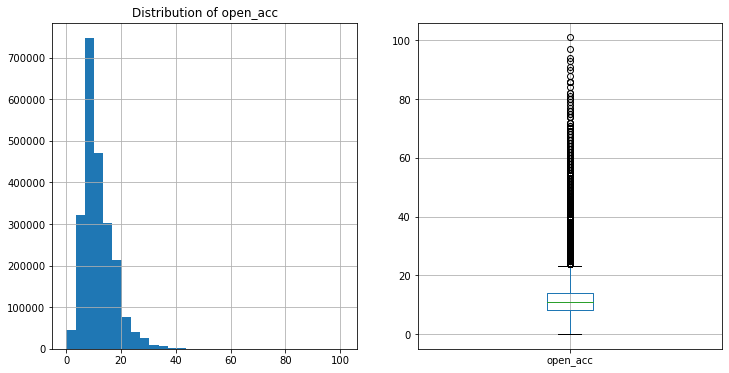

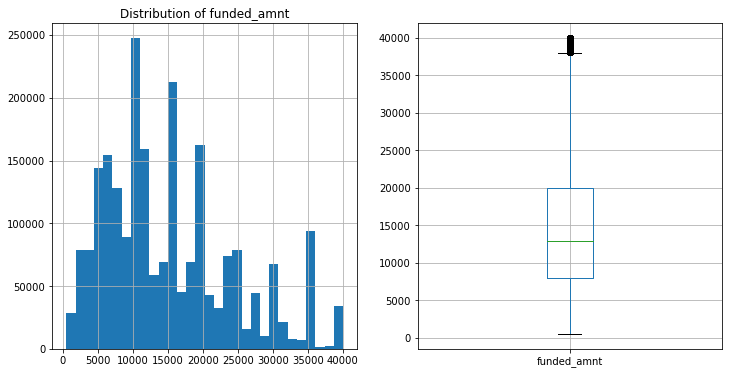

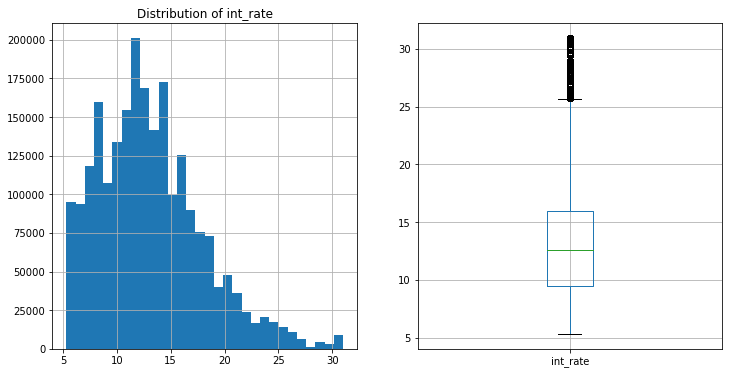

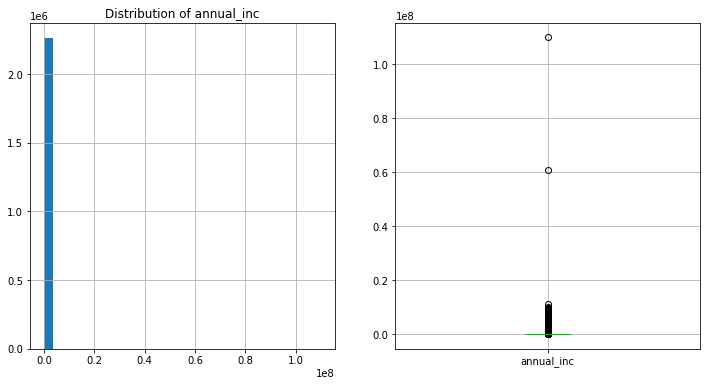

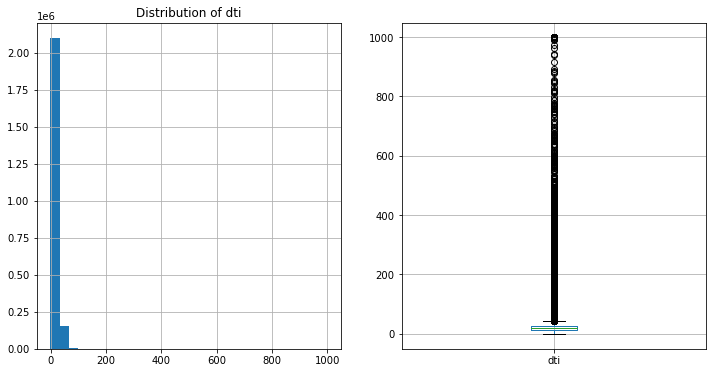

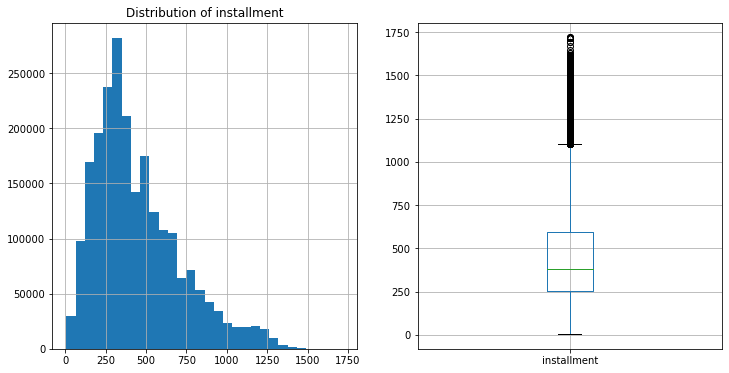

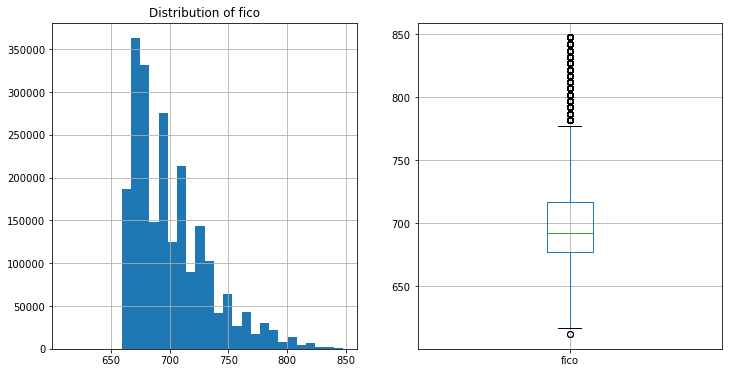

In [18]:
#Code borrowed from COMP488 notebook. 
#We are using histograms and box-plots to check for outliers
#Creating a for loop running through float types
for col in data[float_types]:
    #For each column we create space for one row with 2 charts 
    f, axes = plt.subplots(1, 2, figsize=(12, 6))
    #The first chart is a histogram 
    data[float_types][col].hist(bins = 30, ax = axes[0])
    #The title for the chart is created here 
    axes[0].set_title('Distribution of '+ col)
    #The boxplot is created for the column
    data[float_types].boxplot(column = col, ax = axes[1])
    #This command displays the charts
    plt.show()

# Define a function that identifies outlier cases

In [19]:
#Code borrowed from COMP488 notebook.
#We are defining a function that can be used on any dataset to return a list of index values for the outliers 
def get_outliers(data, columns):
    #We create an empty list
    outlier_idxs = []
     #The standard deviations needed
    nsd = 3 
    #We loop over all columns passed into the function
    for col in columns:
        elements = data[col]
        #We get the mean value for each column
        mean = elements.mean()
        #We get the standard deviation of the column
        sd = elements.std()
        #We get the index values of all values higher or lower than the mean +/- nsd standard deviations
        outliers_mask = data[(data[col] > mean + nsd*sd) | (data[col]  < mean  - nsd*sd)].index
        #We add those index values to our list
        outlier_idxs  += [x for x in outliers_mask]
        #We return a list of the outliers index
    return list(set(outlier_idxs))

# Call the function that identifies outliers. 
- drop the idenitied outliers from out data
### Caution: Running this function call multiple times will continue to decrease the size of your data


In [20]:
#We check how many observations we have and print the results
print (f"Number of Observations and Features before Cleaning: {data[float_types].shape}")
#We call the function we just created on the boston dataset
outliers = get_outliers(data[float_types], float_types)
#We drop those records from our feature and response data
data = data.drop(outliers, axis = 0)
#We check that this code has worked by looking at the shape of our data 
print (f"Number of Observations and Features after Cleaning: {data[float_types].shape}")
#Careful when running cell as more data will be removed

Number of Observations and Features before Cleaning: (2260668, 7)
Number of Observations and Features after Cleaning: (2152667, 7)


# Re-examine the distirbution for each features, now that we have dropped outlier cases

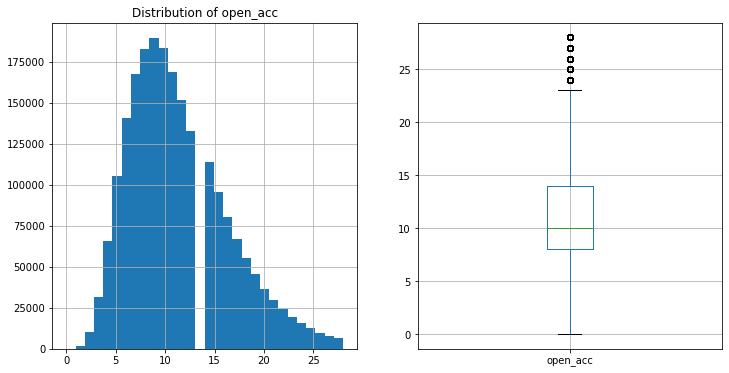

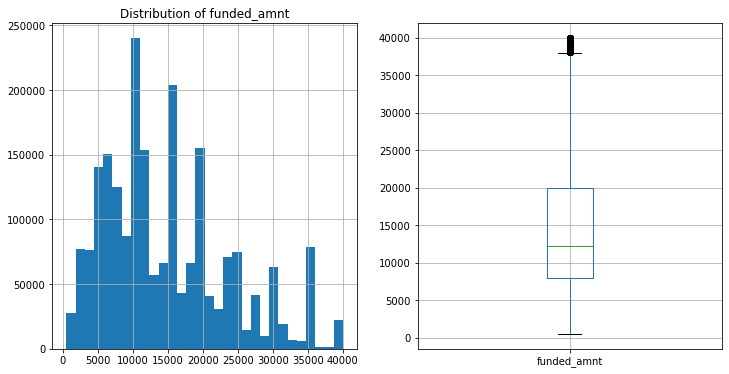

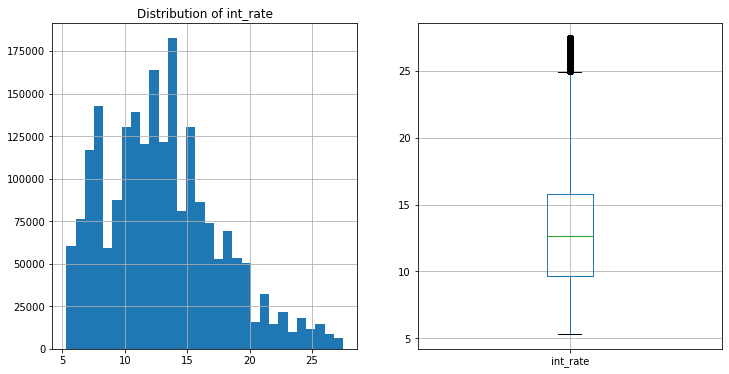

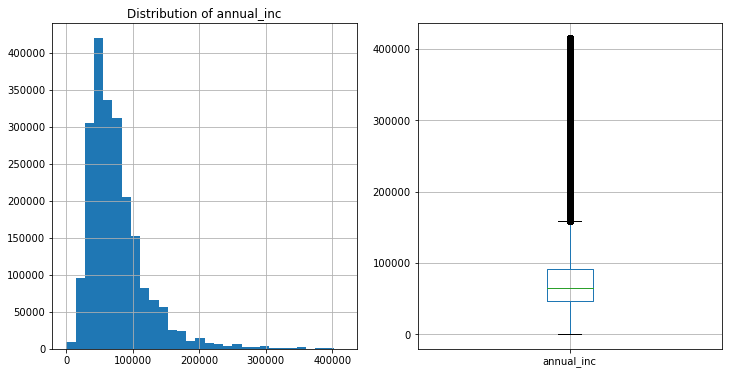

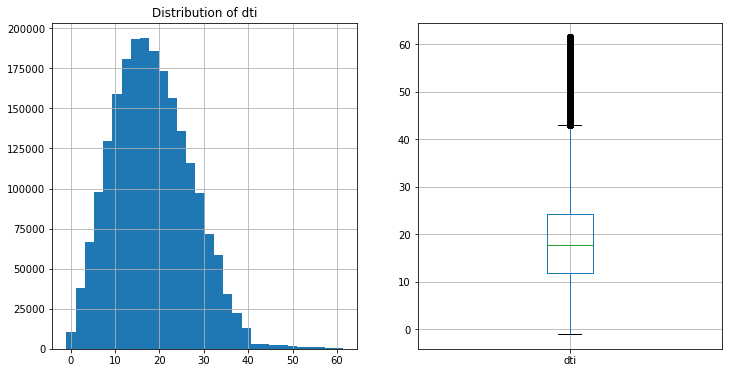

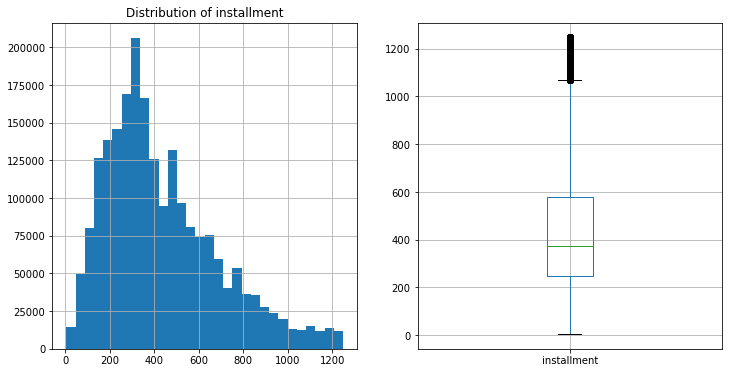

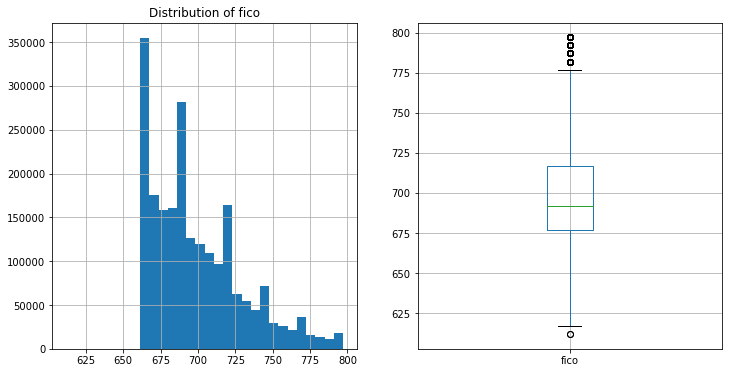

In [21]:
#Code borrowed from COMP488 notebook.
#Checking histogram and box plots after removing outliers in for loop
for col in data[float_types]:
    #For each column we create space for one row with 2 charts  
    f, axes = plt.subplots(1, 2, figsize=(12, 6))
    #Our first chart is a histogram and we set the title 
    data[float_types][col].hist(bins = 30, ax = axes[0])
    #We set the title of our histogram
    axes[0].set_title('Distribution of '+ col)
    #We created a boxplot of the column
    data[float_types].boxplot(column = col, ax = axes[1])
    #We use this to command to display the charts
    plt.show()

# Feature Engineering: 

## The next portion of this notebook focuses on preparing key features for out model.  

### Loan Status 
   - There are multiple levels to the loan status: Fully Paid, Current, Charged Off, Late (31-120 days), In Grace Period, Late (16-30 days), Does not meet the credit policy. Status: Fully Paid,  Does not meet the credit policy. Staus: Charged Off, and Default. 
   - We narrow our focus to just include the Charged Off and Fully Paid Loans because these are the only loans for which we know their ending status. 

# Loan Status
- Look at the contents of the feature using value_counts
- drop the loans that are not in a definite ending status. 

In [22]:
#Count unique values in loan status
data['loan_status'].value_counts()

Fully Paid                                             1036043
Current                                                 826481
Charged Off                                             255751
Late (31-120 days)                                       19847
In Grace Period                                           7782
Late (16-30 days)                                         4024
Does not meet the credit policy. Status:Fully Paid        1955
Does not meet the credit policy. Status:Charged Off        750
Default                                                     34
Name: loan_status, dtype: int64

In [23]:
# dropping loans that are not of Full Paid Off or Charged Off status 
s_drop = ['Current', 'Does not meet the credit policy. Status:Charged Off', 'Does not meet the credit policy. Status:Fully Paid', 'In Grace Period', 'Late (16-30 days)', 'Late (31-120 days)']
#Retrives the data of loan status that are fully paid or charged off
data_c = data.loc[(data['loan_status'] == "Fully Paid") | (data['loan_status'] == "Charged Off")].copy()
#Remove the unused categories in loan status
data_c['loan_status'] = data_c['loan_status'].cat.remove_unused_categories()
#Determine the counts on loan status for fully paid and charged off
data_c['loan_status'].value_counts()

Fully Paid     1036043
Charged Off     255751
Name: loan_status, dtype: int64

# An exploratory look at how the two loan status levels relate to the loan sub-grade. 

In [24]:
#Group based on sub grade and loan status with respective sums of other variables in following columns
data_c.groupby((["sub_grade","loan_status"])).sum()
tab = pd.crosstab(index = data_c['sub_grade'], columns = data_c['loan_status'])
#Print the tab object
print(tab)

loan_status  Charged Off  Fully Paid
sub_grade                           
A1                  1282       36546
A2                  1633       32699
A3                  1994       34043
A4                  3447       46636
A5                  5190       56493
B1                  7156       61870
B2                  8166       63988
B3                 10363       69592
B4                 12085       69473
B5                 13499       67371
C1                 15888       67942
C2                 16078       61711
C3                 16559       57003
C4                 18183       54817
C5                 17186       49020
D1                 13841       36043
D2                 12819       30496
D3                 11460       26096
D4                 11047       23025
D5                  9531       19022
E1                  8216       14516
E2                  7684       12794
E3                  6825       10838
E4                  6080        9087
E5                  5802        8091
F

# Random Forest: 
- We begin our analysis with a baseline Random Forest Model 
    - The first few cells focus on ensuring the data is correctly type casted and gaining an overview of our data. 

In [25]:
#Print head of cleaned data
data_c.head()

,open_acc,funded_amnt,int_rate,term,verification_status,annual_inc,dti,installment,application_type,emp_length,grade,sub_grade,home_ownership,loan_status,issue_d,fico,issue_yr
0,7.0,3600.0,13.99,36,Not Verified,55000.0,5.91,123.03,Individual,10+ years,C,C4,MORTGAGE,Fully Paid,Dec-2015,677.0,2015
1,22.0,24700.0,11.99,36,Not Verified,65000.0,16.06,820.28,Individual,10+ years,C,C1,MORTGAGE,Fully Paid,Dec-2015,717.0,2015
2,6.0,20000.0,10.78,60,Not Verified,63000.0,10.78,432.66,Joint App,10+ years,B,B4,MORTGAGE,Fully Paid,Dec-2015,697.0,2015
4,12.0,10400.0,22.45,60,Source Verified,104433.0,25.37,289.91,Individual,3 years,F,F1,MORTGAGE,Fully Paid,Dec-2015,697.0,2015
5,5.0,11950.0,13.44,36,Source Verified,34000.0,10.20,405.18,Individual,4 years,C,C3,RENT,Fully Paid,Dec-2015,692.0,2015


In [26]:
#Print head of cleaned data
data_c['term'] = data_c['term'].astype(int)
#Converting issue year to a data type of integer
data_c['issue_yr'] = data_c['issue_yr'].astype(int)
#Dropping issue date column
data_c = data_c.drop(['issue_d'], axis = 1)

In [27]:
#Checking what is in cleaned data now after type casting and dropping variables
data_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1291794 entries, 0 to 2260697
Data columns (total 16 columns):
 #   Column               Non-Null Count    Dtype   
---  ------               --------------    -----   
 0   open_acc             1291794 non-null  float64 
 1   funded_amnt          1291794 non-null  float64 
 2   int_rate             1291794 non-null  float64 
 3   term                 1291794 non-null  int32   
 4   verification_status  1291794 non-null  category
 5   annual_inc           1291794 non-null  float64 
 6   dti                  1291451 non-null  float64 
 7   installment          1291794 non-null  float64 
 8   application_type     1291794 non-null  category
 9   emp_length           1216733 non-null  category
 10  grade                1291794 non-null  category
 11  sub_grade            1291794 non-null  category
 12  home_ownership       1291794 non-null  category
 13  loan_status          1291794 non-null  category
 14  fico                 1291794 non-n

In [28]:
#Finding the sum of the missing values in the cleaned data
data_c.isna().sum()
#Drop the cases of missing values
data_c = data_c.dropna(axis = 1)
#Confirm the missing value some is now 0 after dropping from before
data_c.isnull().sum()

open_acc               0
funded_amnt            0
int_rate               0
term                   0
verification_status    0
annual_inc             0
installment            0
application_type       0
grade                  0
sub_grade              0
home_ownership         0
loan_status            0
fico                   0
issue_yr               0
dtype: int64

In [29]:
#Make a copy of the grade column
grade = data_c['grade'].copy()
#Make a copy of the sub grade column
sub_grade = data_c['sub_grade'].copy()
#Keep the data with issue years greater than 2012
mod_dt = data_c[(data_c["issue_yr"] >= 2012)]
#Checking all possible issue years that are there now
mod_dt['issue_yr'].unique()

array([2015, 2018, 2017, 2016, 2014, 2013, 2012])

# Split the data into Testing and Training data sets 
- Our training data includes observations where a loan was issued from 2012 -2016
-Our testing data includes observations where a loan was issued from 2017-2018

### In order to check that the split occured as expected, we count the number of unique values in the 'issue_yr' feature for our training and testing data. 

In [30]:
#Assigning test data to be all data with an issue year greater than or equal to 2017
test_data = mod_dt[mod_dt['issue_yr'] >= 2017]
#Assigning training data to be all data with an issue year less than 2017
train_data = mod_dt[mod_dt['issue_yr'] < 2017]
#Printing the number of unique values in the testing data's issue year column. We expect two
print(test_data['issue_yr'].nunique())
#Printing the number of unique values in the training data's issue year column. We expect five
print(train_data['issue_yr'].nunique())

2
5


In [31]:
#Current columns in training data
train_data.columns

#Create a new dataframe X that includes only our feature variables
X_train = train_data.loc[:,data_c.columns != 'loan_status'].copy()
#Create a new dataframe y that includes only our feature variables
y_train = train_data['loan_status'].copy()
#Retrieve everything but the loan status column from X test data
X_test = test_data.loc[:,data_c.columns != 'loan_status'].copy()
#Retrieve the loan status column from y test data
y_test = test_data['loan_status'].copy()
#One hot encode the categorical features to make them machine readable for X_test 
X_test = pd.get_dummies(X_test, drop_first=False).copy()
#One hot encode the categorical features to make them machine readable for X_train 
X_train= pd.get_dummies(X_train, drop_first=False).copy()
#Show the first five rows of X_train
display(X_train.head())
#Calculate the sum of the missing values from the X training data
X_train.isna().sum()
#Calculate the sum of the missing values from the y training data
y_train.isnull().sum()
#Shows us the number of rows and columns in y_train
y_train.shape

,open_acc,funded_amnt,int_rate,term,annual_inc,installment,fico,issue_yr,verification_status_Not Verified,verification_status_Source Verified,...,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,7.0,3600.0,13.99,36,55000.0,123.03,677.0,2015,1,0,...,0,0,0,0,0,1,0,0,0,0
1,22.0,24700.0,11.99,36,65000.0,820.28,717.0,2015,1,0,...,0,0,0,0,0,1,0,0,0,0
2,6.0,20000.0,10.78,60,63000.0,432.66,697.0,2015,1,0,...,0,0,0,0,0,1,0,0,0,0
4,12.0,10400.0,22.45,60,104433.0,289.91,697.0,2015,0,1,...,0,0,0,0,0,1,0,0,0,0
5,5.0,11950.0,13.44,36,34000.0,405.18,692.0,2015,0,1,...,0,0,0,0,0,0,0,0,0,1


(1045866,)

In [32]:

#Store X-train funded_amnt in new object called funded_amnt_unscaled
funded_amnt_unscaled= X_train['funded_amnt'].copy()
#Store X-test funded_amnt in new object called funded_amnt_unscaled_test
funded_amnt_unscaled_test= X_test['funded_amnt'].copy()


# Define a function that will scale features. 
- Since Random Forest relies on Eucladian distrance, feature scaling is a critical step
- This action maintains each feature's disbtribution while removing the effects of different scales on our model

In [33]:
#Borrowed from COMP488 notes
#This function loops through columns in a feature set and defines a predefined scaler for each
def scale_numeric(features, numeric_features, scaler):
    #For loop through each numeric column
    for col in numeric_features:
       #Reshaping the columns
        features[col] = scaler.fit_transform(features[col].values.reshape(-1, 1))
     #Return the columnn
    return features

#We now define the scaler we want to use and apply it to our features 
#Initialize the list of numeric_features
numeric_features = ['open_acc', 'funded_amnt', 'int_rate', 'term', 'annual_inc',
       'installment', 'fico',]
       #Store MinMaxScaler function in scaler object
scaler = MinMaxScaler()
#Call scale_numeric function in X_train
X_train_scaled = scale_numeric(X_train, numeric_features, scaler)
#Call scale_numeric function in X_test
X_test_scaled = scale_numeric(X_test, numeric_features, scaler)
#Check to see if it worked
X_train_scaled.describe()

,open_acc,funded_amnt,int_rate,term,annual_inc,installment,fico,issue_yr,verification_status_Not Verified,verification_status_Source Verified,...,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
count,1.045866e+06,1.045866e+06,1.045866e+06,1.045866e+06,1.045866e+06,1.045866e+06,1.045866e+06,1.045866e+06,1.045866e+06,1.045866e+06,...,1.045866e+06,1.045866e+06,1.045866e+06,1.045866e+06,1.045866e+06,1.045866e+06,1.045866e+06,1.045866e+06,1.045866e+06,1.045866e+06
mean,4.079238e-01,3.414668e-01,3.528754e-01,2.386262e-01,1.770765e-01,3.454165e-01,2.462024e-01,2.014655e+03,2.889672e-01,3.922539e-01,...,1.131120e-03,5.822926e-04,3.566422e-04,3.164841e-04,6.119331e-05,4.917418e-01,4.015811e-05,4.302654e-05,1.047257e-01,4.033882e-01
std,1.755348e-01,2.140426e-01,2.025024e-01,4.262439e-01,1.027593e-01,1.981693e-01,2.099295e-01,1.145052e+00,4.532829e-01,4.882530e-01,...,3.361312e-02,2.412372e-02,1.888162e-02,1.778719e-02,7.822380e-03,4.999320e-01,6.336918e-03,6.559324e-03,3.061997e-01,4.905776e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.012000e+03,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.857143e-01,1.794872e-01,1.998196e-01,0.000000e+00,1.081731e-01,2.006069e-01,7.407407e-02,2.014000e+03,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.928571e-01,2.820513e-01,3.369418e-01,0.000000e+00,1.560096e-01,2.997835e-01,1.851852e-01,2.015000e+03,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,5.000000e-01,4.871795e-01,4.727109e-01,0.000000e+00,2.163462e-01,4.579299e-01,3.703704e-01,2.016000e+03,1.000000e+00,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.016000e+03,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [34]:
#Check to see the missing values in X_train_scaled
X_train_scaled.isna().sum()

open_acc                   0
funded_amnt                0
int_rate                   0
term                       0
annual_inc                 0
                          ..
home_ownership_MORTGAGE    0
home_ownership_NONE        0
home_ownership_OTHER       0
home_ownership_OWN         0
home_ownership_RENT        0
Length: 61, dtype: int64

# This is assurance that our testing and training data have symmetrical shapes. 

In [35]:

#Check if data have right shape
#Print the train response variable shape
print("Train: Response Variable: ",y_train.shape)
#Print the train feature variables shape
print("Train: Feature Variables: ",X_train_scaled.shape)
#Print the test response variable shape
print("Test: Response Variable: ",y_test.shape)
#Print the test feature variables shape
print("Test: Feature Variables: ",X_test_scaled.shape)

Train: Response Variable:  (1045866,)
Train: Feature Variables:  (1045866, 61)
Test: Response Variable:  (206921,)
Test: Feature Variables:  (206921, 61)


In [36]:
#Instantiate a random forests classifier
rf = RandomForestClassifier(n_estimators=25, criterion='gini')
#Fit'rf' to the training set
rf.fit(X_train_scaled, y_train)
#Predict the test set labels 'y_pred'
y_pred = rf.predict(X_test_scaled)
#Print model accuracy
print(f'Model Accuracy is {accuracy_score(y_test, y_pred)}\n')

Model Accuracy is 0.7760014691597277



# Model Performance
- we look at a confusion matrix to evaluate the performance of our model. 
- this will give us a better understanding than simly looking at the accuracy score reported above

              precision    recall  f1-score   support

 Charged Off       0.38      0.13      0.19     42731
  Fully Paid       0.81      0.94      0.87    164190

    accuracy                           0.78    206921
   macro avg       0.59      0.54      0.53    206921
weighted avg       0.72      0.78      0.73    206921



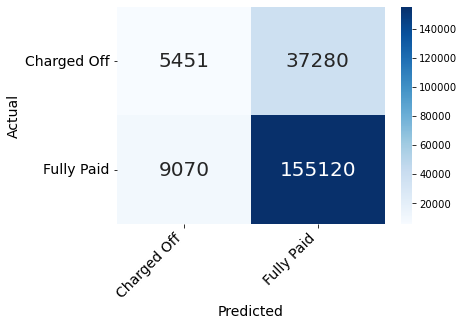

In [37]:
#Borrowed from COMP488 notes
#Visualize the confusion matrix to make it easier to read
con_matrix = confusion_matrix(y_test, y_pred)
#Create data frame with confusion matrix labels of charged off and fully paid
confusion_matrix_df = pd.DataFrame(con_matrix, ('Charged Off', 'Fully Paid'), ('Charged Off', 'Fully Paid'))
#Initialize the heatmap confusion matrix
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
#Edit the y axis labels on the heatmap confusion matrix
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
#Edit the x axis labels on the heatmap confusion matrix
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
#Plot the y label actual on the matrix
plt.ylabel('Actual', fontsize = 14)
#Plot the x label predicted on the matrix
plt.xlabel('Predicted', fontsize = 14)
# Print the classification report
print(classification_report(y_test, y_pred))


# Improved Random Forest Model (Model 2)

## Upsampling

- We realized that one major issue with our baseline random forest model is the asymmetry in our training data along our y variable. 
   - Our model is predicitng loan status
   -However, our data has many more 'Fully Paid' loans when compared to 'Charged Off' loans.
- We will upsample the number of 'Charged Off' loans in our training data, so that our model will be able to perform better on our testing data. 

In [38]:
#Create object minority that contains a loan status of charged off
minority = train_data[train_data['loan_status'] == 'Charged Off']
#Create object majority that contains a loan status of fully paid
majority = train_data[train_data['loan_status'] == 'Fully Paid']

In [39]:
#Creating half the data by resampling on the size of the majority sample
minority_upsampled = resample(minority, replace = True, n_samples = len(majority.index))
#Join the majority sample and upsampled minority in one object
upsampled_data = majority.append(minority_upsampled)

C:\Users\kangd\AppData\Local\Temp\ipykernel_99544\337745525.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  upsampled_data = majority.append(minority_upsampled)


In [40]:
#Find the number of charged off and fully paid loans in the unsampled_data
upsampled_data.groupby(['loan_status']).count()

,open_acc,funded_amnt,int_rate,term,verification_status,annual_inc,installment,application_type,grade,sub_grade,home_ownership,fico,issue_yr
loan_status,,,,,,,,,,,,,
Charged Off,838453,838453,838453,838453,838453,838453,838453,838453,838453,838453,838453,838453,838453
Fully Paid,838453,838453,838453,838453,838453,838453,838453,838453,838453,838453,838453,838453,838453


# Split our upsampled data into a training and testing set
- the training data contains cases from years 2012 -2016
- the testing data contains csaes from years 2017-2018

In [41]:
#Keep the data with issue years greater than 2012
mod_dt = upsampled_data[(upsampled_data["issue_yr"] >= 2012)]
#Assigning test data to be all data with an issue year greater than or equal to 2017
upsampled_test_data = mod_dt[mod_dt['issue_yr'] >= 2017]
#Assigning training data to be all data with an issue year less than 2017
upsampled_train_data = mod_dt[mod_dt['issue_yr'] < 2017]

In [42]:
# 1 Create a new dataframe X that includes only our feature variables
X_upsampled_train = upsampled_train_data.loc[:,upsampled_data.columns != 'loan_status'].copy()
#Create a new dataframe y that includes loan status
y_upsampled_train = upsampled_train_data['loan_status'].copy()
#Now you need to one hot encode the categorical features to make them machine readable. 
X_upsampled_train = pd.get_dummies(X_upsampled_train, drop_first=False).copy()
#Show the first five rows of X_upsampled_train
display(X_upsampled_train.head())

,open_acc,funded_amnt,int_rate,term,annual_inc,installment,fico,issue_yr,verification_status_Not Verified,verification_status_Source Verified,...,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,7.0,3600.0,13.99,36,55000.0,123.03,677.0,2015,1,0,...,0,0,0,0,0,1,0,0,0,0
1,22.0,24700.0,11.99,36,65000.0,820.28,717.0,2015,1,0,...,0,0,0,0,0,1,0,0,0,0
2,6.0,20000.0,10.78,60,63000.0,432.66,697.0,2015,1,0,...,0,0,0,0,0,1,0,0,0,0
4,12.0,10400.0,22.45,60,104433.0,289.91,697.0,2015,0,1,...,0,0,0,0,0,1,0,0,0,0
5,5.0,11950.0,13.44,36,34000.0,405.18,692.0,2015,0,1,...,0,0,0,0,0,0,0,0,0,1


In [43]:
#This function loops through columns in a feature set and defines a predefined scaler to each
def scale_numeric(features, numeric_features, scaler):
  #For loop through the numeric features
    for col in numeric_features:
      #Reshaping the column
        features[col] = scaler.fit_transform(features[col].values.reshape(-1, 1))
    #Return the column
    return features

#We can now define the scaler we want to use and apply it to our features 
#Create an array called numeric_features with numeric variables
numeric_features = ['open_acc', 'funded_amnt', 'int_rate', 'term', 'annual_inc',
       'installment', 'fico']
       #Store the minmax scaler in scaler
scaler = MinMaxScaler()
#Call scale_numeric function in X_upsampled_train
X_upsampled_train = scale_numeric(X_upsampled_train, numeric_features, scaler)
#Check to see if it worked
X_upsampled_train.describe()

,open_acc,funded_amnt,int_rate,term,annual_inc,installment,fico,issue_yr,verification_status_Not Verified,verification_status_Source Verified,...,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
count,1.676906e+06,1.676906e+06,1.676906e+06,1.676906e+06,1.676906e+06,1.676906e+06,1.676906e+06,1.676906e+06,1.676906e+06,1.676906e+06,...,1.676906e+06,1.676906e+06,1.676906e+06,1.676906e+06,1.676906e+06,1.676906e+06,1.676906e+06,1.676906e+06,1.676906e+06,1.676906e+06
mean,4.120797e-01,3.505037e-01,3.920245e-01,2.987496e-01,1.720594e-01,3.505226e-01,2.266917e-01,2.014707e+03,2.599728e-01,4.006492e-01,...,1.699559e-03,8.360636e-04,5.462441e-04,4.997299e-04,5.784463e-05,4.679099e-01,3.816553e-05,4.711057e-05,1.059421e-01,4.260048e-01
std,1.766576e-01,2.145533e-01,2.090216e-01,4.577100e-01,9.939024e-02,1.963440e-01,1.994886e-01,1.134180e+00,4.386195e-01,4.900302e-01,...,4.119067e-02,2.890268e-02,2.336549e-02,2.234906e-02,7.605348e-03,4.989693e-01,6.177709e-03,6.863554e-03,3.077636e-01,4.944945e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.012000e+03,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.857143e-01,1.794872e-01,2.557510e-01,0.000000e+00,1.081731e-01,2.081009e-01,7.407407e-02,2.014000e+03,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.928571e-01,3.076923e-01,3.761840e-01,0.000000e+00,1.490385e-01,3.064564e-01,1.851852e-01,2.015000e+03,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,5.000000e-01,4.871795e-01,5.263870e-01,1.000000e+00,2.074519e-01,4.616245e-01,3.333333e-01,2.016000e+03,1.000000e+00,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.016000e+03,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [44]:
#Check if data have right shape
#Print the Train: Response Variable shape
print("Train: Response Variable: ",y_upsampled_train.shape)
#Print the Train: Feature Variable shape
print("Train: Feature Variables: ",X_upsampled_train.shape)
#Print the Test: Response Variable shape
print("Test: Response Variable: ",y_test.shape)
#Print the Test: Feature Variable shape
print("Test: Feature Variables: ",X_test.shape)

Train: Response Variable:  (1676906,)
Train: Feature Variables:  (1676906, 61)
Test: Response Variable:  (206921,)
Test: Feature Variables:  (206921, 61)


In [45]:
#Fit 'rf' to the rf_upsampled set
rf_upsampled = RandomForestClassifier(n_estimators=25, criterion='gini')
#Fit 'rf' to the rf_upsampled.fit training set
rf_upsampled.fit(X_upsampled_train, y_upsampled_train)
#Predict the test set labels 'y_pred'
y_upsampled_pred = rf_upsampled.predict(X_test)
#Print the model accuracy
print(f'Model Accuracy is {accuracy_score(y_test, y_upsampled_pred)}\n')

Model Accuracy is 0.7505569758506869



              precision    recall  f1-score   support

 Charged Off       0.34      0.22      0.27     42731
  Fully Paid       0.81      0.89      0.85    164190

    accuracy                           0.75    206921
   macro avg       0.58      0.56      0.56    206921
weighted avg       0.72      0.75      0.73    206921



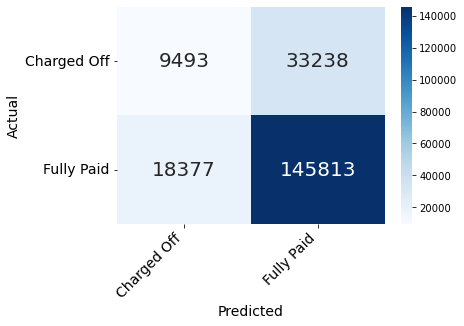

In [46]:
#Borrowed from COMP488 notes
#Visualize the confusion matrix to make it easier to read
con_matrix = confusion_matrix(y_test, y_upsampled_pred)
#Create data frame with confusion matrix labels of charged off and fully paid
confusion_matrix_df = pd.DataFrame(con_matrix, ('Charged Off', 'Fully Paid'), ('Charged Off', 'Fully Paid'))
#Initialize the heatmap confusion matrix
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
#Edit the y axis labels on the heatmap confusion matrix
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
#Edit the x axis labels on the heatmap confusion matrix
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
#Plot the y label actual on the matrix
plt.ylabel('Actual', fontsize = 14)
#Plot the x label predicted on the matrix
plt.xlabel('Predicted', fontsize = 14)
# Print the classification report
print(classification_report(y_test, y_upsampled_pred))

# Evaluating Model Performance
- we will be using a confusion matrix t evaluate the performance of our model.

# Naive Bayes Model 

In [47]:
nb = MultinomialNB()

In [48]:
nb.fit(X_train_scaled, y_train)

MultinomialNB()

In [49]:
nb_pred = nb.predict(X_test_scaled)

print(f'Model Accuracy is {accuracy_score(y_test, nb_pred)}\n')

Model Accuracy is 0.7641273722821753



# Evaluating Model Performance
- we will be using a confusion matrix t evaluate the performance of our model.

              precision    recall  f1-score   support

 Charged Off       0.38      0.22      0.28     42731
  Fully Paid       0.82      0.91      0.86    164190

    accuracy                           0.76    206921
   macro avg       0.60      0.56      0.57    206921
weighted avg       0.73      0.76      0.74    206921



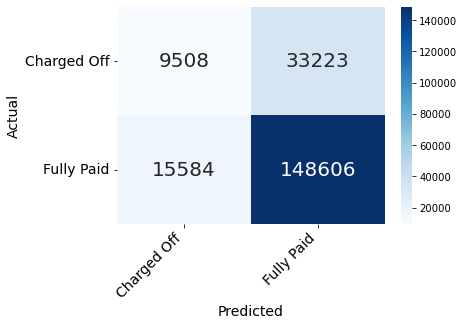

In [50]:
#Borrowed from COMP488 notes
#Visualize the confusion matrix to make it easier to read
con_matrix = confusion_matrix(y_test, nb_pred)
#Create data frame with confusion matrix labels of charged off and fully paid
confusion_matrix_df = pd.DataFrame(con_matrix, ('Charged Off', 'Fully Paid'), ('Charged Off', 'Fully Paid'))
#Initialize the heatmap confusion matrix
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
#Edit the y axis labels on the heatmap confusion matrix
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
#Edit the x axis labels on the heatmap confusion matrix
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
#Plot the y label actual on the matrix
plt.ylabel('Actual', fontsize = 14)
#Plot the x label predicted on the matrix
plt.xlabel('Predicted', fontsize = 14)
# Print the classification report
print(classification_report(y_test, nb_pred))


# K-Nearest Neighbors (KNN)

In [51]:
knn = KNeighborsClassifier(n_neighbors = 9) 
knn.fit(X_train_scaled, y_train)
knn_pred = knn.predict(X_test_scaled)

print(f'Model Accuracy is {accuracy_score(y_test, knn_pred)}\n')

Model Accuracy is 0.7695980591626757



              precision    recall  f1-score   support

 Charged Off       0.36      0.14      0.21     42731
  Fully Paid       0.81      0.93      0.87    164190

    accuracy                           0.77    206921
   macro avg       0.58      0.54      0.54    206921
weighted avg       0.71      0.77      0.73    206921



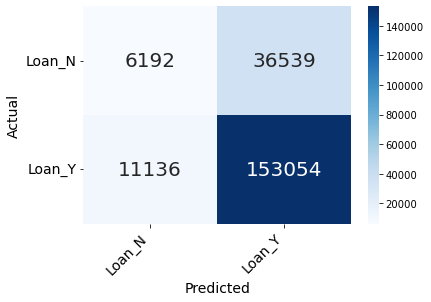

In [52]:
con_matrix = confusion_matrix(y_test, knn_pred)
confusion_matrix_df = pd.DataFrame(con_matrix, ('Loan_N', 'Loan_Y'), ('Loan_N', 'Loan_Y'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)
print(classification_report(y_test, knn_pred))